In [1]:
import odc.stac
import rioxarray
import requests
import shapely
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import osmnx
import pystac_client
import planetary_computer
import matplotlib.colors
import matplotlib.ticker as mticker
import pystac_client
import planetary_computer


In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [3]:
start_date = "2025-01-01"
end_date = "2025-01-31"

rainier_bbox_gdf = gpd.read_file("/home/jovyan/WILDFIRE/Yogerej_Folder/palisade.geojson")
bbox = rainier_bbox_gdf.total_bounds
bbox


array([-118.7322309 ,   34.01863512, -118.49918034,   34.13057559])

In [4]:
search = catalog.search(
    collections=["sentinel-2-l2a"], # sentinel-2-c1-l2a if using earthsearch
    bbox=bbox,
    datetime=(start_date, end_date), 
    #query={"eo:cloud_cover": {"lt": 30}},
)

items = search.item_collection()
items

In [5]:
bands = ["B02", "B03", "B04", "B08", "B09", "B11", "B12"]  # Red, NIR

s2_ds = odc.stac.load(items,
                      bands=bands, 
                      #chunks={"x": 256, "y": 256},
                      resolution=10,
                      chunks={},
                      groupby='solar_day',
                      bbox=bbox,
)

s2_ds

<xarray.Dataset> Size: 388MB
Dimensions:      (y: 1276, x: 2172, time: 5)
Coordinates:
  * y            (y) float64 10kB 3.778e+06 3.778e+06 ... 3.765e+06 3.765e+06
  * x            (x) float64 17kB 3.401e+05 3.401e+05 ... 3.618e+05 3.618e+05
    spatial_ref  int32 4B 32611
  * time         (time) datetime64[ns] 40B 2025-01-02T18:37:51.024000 ... 202...
Data variables:
    B02          (time, y, x) float32 55MB dask.array<chunksize=(1, 1276, 2172), meta=np.ndarray>
    B03          (time, y, x) float32 55MB dask.array<chunksize=(1, 1276, 2172), meta=np.ndarray>
    B04          (time, y, x) float32 55MB dask.array<chunksize=(1, 1276, 2172), meta=np.ndarray>
    B08          (time, y, x) float32 55MB dask.array<chunksize=(1, 1276, 2172), meta=np.ndarray>
    B09          (time, y, x) float32 55MB dask.array<chunksize=(1, 1276, 2172), meta=np.ndarray>
    B11          (time, y, x) float32 55MB dask.array<chunksize=(1, 1276, 2172), meta=np.ndarray>
    B12          (time, y, x) float32 55MB dask.array<chunksize=(1, 1276, 2172), meta=np.ndarray>

In [6]:
ndvi_da = (s2_ds["B08"] - s2_ds["B04"]) / (s2_ds["B08"] + s2_ds["B04"])
ndvi_da

<xarray.DataArray (time: 5, y: 1276, x: 2172)> Size: 55MB
dask.array<truediv, shape=(5, 1276, 2172), dtype=float32, chunksize=(1, 1276, 2172), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 10kB 3.778e+06 3.778e+06 ... 3.765e+06 3.765e+06
  * x            (x) float64 17kB 3.401e+05 3.401e+05 ... 3.618e+05 3.618e+05
    spatial_ref  int32 4B 32611
  * time         (time) datetime64[ns] 40B 2025-01-02T18:37:51.024000 ... 202...

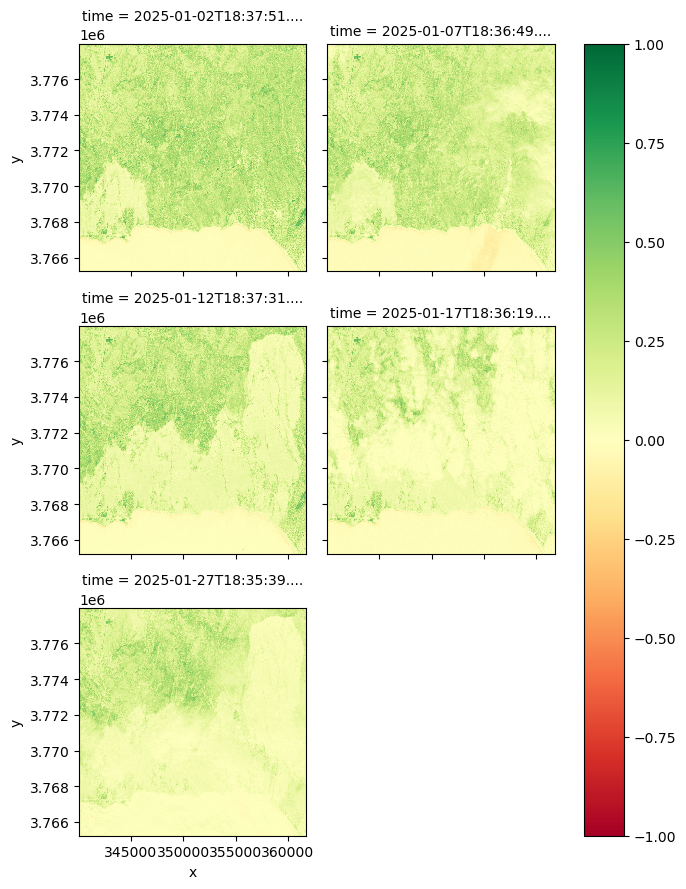

In [7]:
ndvi_da.plot.imshow(col='time',col_wrap=2,robust=True,cmap='RdYlGn',vmin=-1,vmax=1)

In [8]:
#bad_scl = [0,1,2,3,8,9,10]

#ndvi_masked_da = ndvi_da.where(~s2_ds['SCL'].isin(bad_scl)).compute()

#ndvi_masked_da.plot.imshow(col='time',col_wrap=2,robust=True,cmap='RdYlGn',vmin=-1,vmax=1)

**Green Normalized Difference Vegetation Index (GNDVI)**
* Modified version of NDVI to be more sensitive to the variation of chlorophyll content in the crop. “ The highest correlation values with leaf N content and DM were obtained with the GNDVI index in all data acquisition periods and both experimental phases. … GNDVI was more sensible than NDVI to identify different concentration rates of chlorophyll, which is highly correlated at nitrogen, in two species of plants.” ([Gitelson et al. 1996](https://www.researchgate.net/profile/Anatoly-Gitelson))

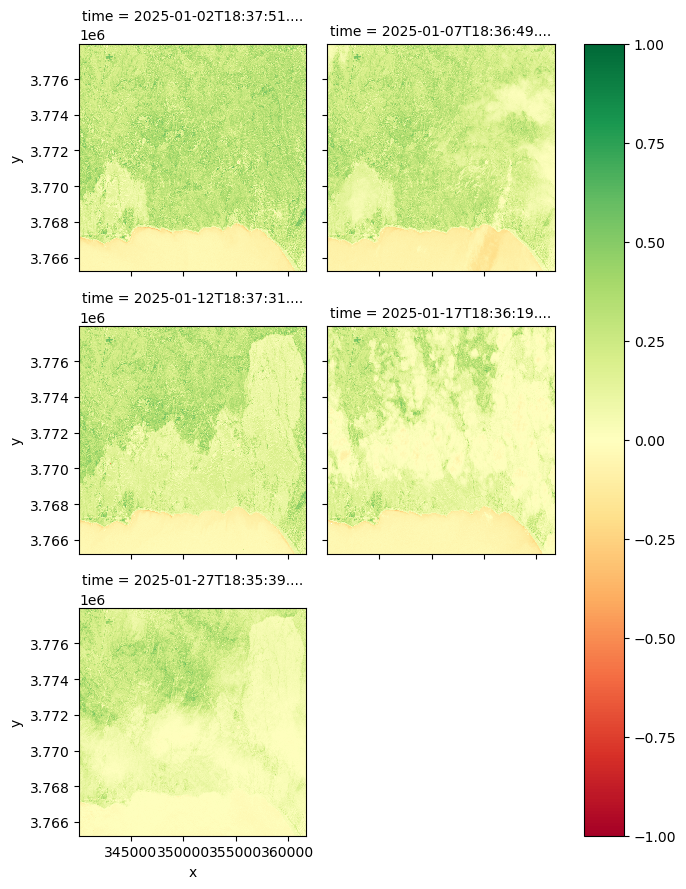

In [9]:
gndvi_da = (s2_ds["B08"] - s2_ds["B03"]) / (s2_ds["B08"] + s2_ds["B03"])
gndvi_da.plot.imshow(col='time',col_wrap=2,robust=True,cmap='RdYlGn',vmin=-1,vmax=1)

**Enhanced Vegetation Index (EVI)**
* EVI is similar to Normalized Difference Vegetation Index (NDVI) and can be used to quantify vegetation greenness. However, EVI corrects for some atmospheric conditions and canopy background noise and is more sensitive in areas with dense vegetation. It incorporates an “L” value to adjust for canopy background, “C” values as coefficients for atmospheric resistance, and values from the blue band (B).  These enhancements allow for index calculation as a ratio between the R and NIR values, while reducing the background noise, atmospheric noise, and saturation in most cases ([USGS, 2019](https://www.usgs.gov/landsat-missions/landsat-enhanced-vegetation-index?qt-science_support_page_related_con=0#qt-science_support_page_related_con)).

/opt/conda/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)


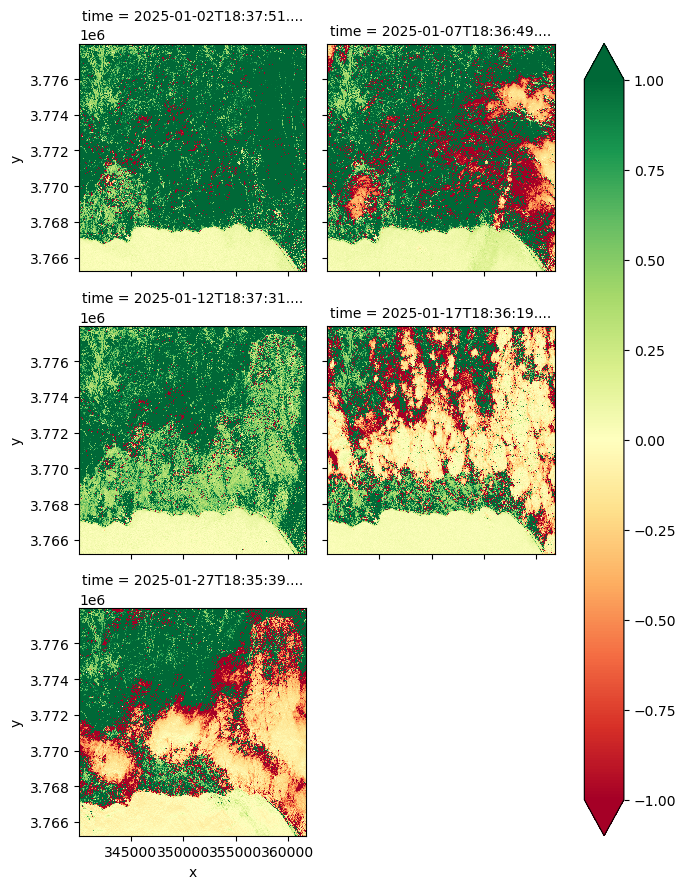

In [10]:
evi_da = 2.5 * ((s2_ds["B08"] - s2_ds["B04"]) / (s2_ds["B08"] + 6 * s2_ds["B04"] - 7.5 * s2_ds["B02"] + 1)) 
evi_da.plot.imshow(col='time',col_wrap=2,robust=True,cmap='RdYlGn',vmin=-1,vmax=1)

**Advanced Vegetation Index (AVI)**
* Numerical indicator, similar to NDVI, that uses the red and near-infrared spectral bands. Like NDVI, AVI is used in vegetation studies to monitor crop and forest variations over time. Through the multi-temporal combination of the AVI and the NDVI, users can discriminate different types of vegetation and extract phenology characteristics/parameters ([GIS Crack](https://giscrack.com/list-of-spectral-indices-for-sentinel-and-landsat/)).

/opt/conda/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in power
  return self.func(*new_argspec)


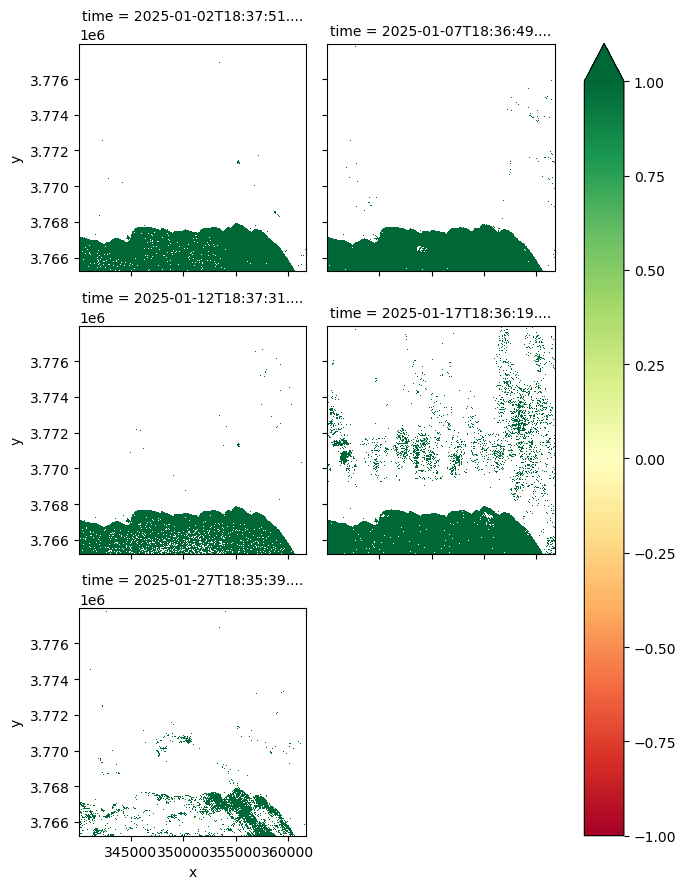

In [11]:
avi_da = (s2_ds["B08"] * (1 - s2_ds["B04"])*(s2_ds["B08"] - s2_ds["B04"])) ** (1/3) 
avi_da.plot.imshow(col='time',col_wrap=2,robust=True,cmap='RdYlGn',vmin=-1,vmax=1)

**Soil Adjusted Vegetation Index (SAVI)**
* SAVI is used to correct Normalized Difference Vegetation Index (NDVI) for the influence of soil brightness in areas where vegetative cover is low. Landsat Surface Reflectance-derived SAVI is calculated as a ratio between the R and NIR values with a soil brightness correction factor (L) defined as 0.5 to accommodate most land cover types ([USGS, 2019](https://www.usgs.gov/landsat-missions/landsat-soil-adjusted-vegetation-index)).

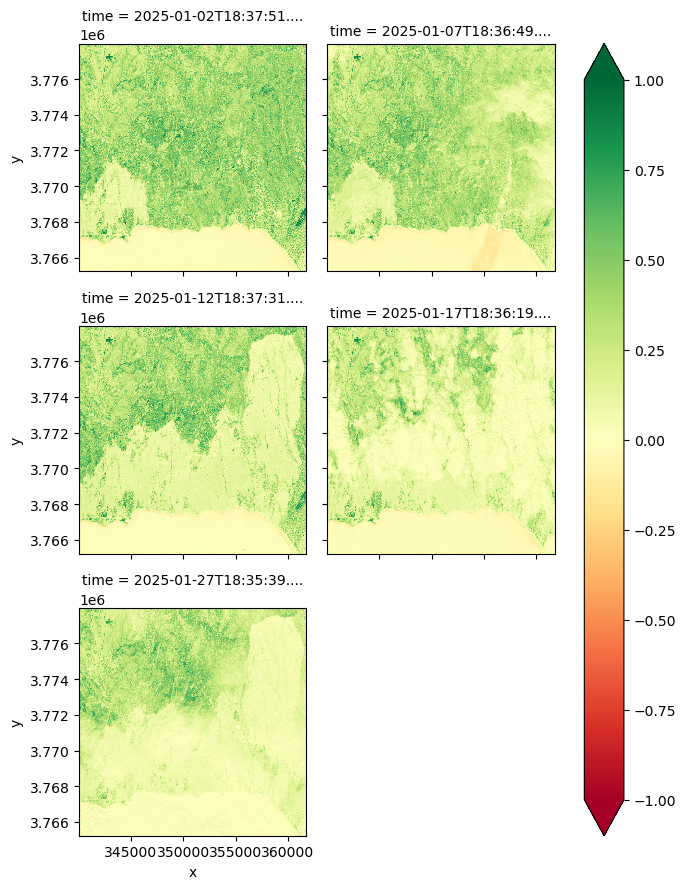

In [12]:
savi_da = (s2_ds["B08"] - s2_ds["B04"]) / (s2_ds["B08"] + s2_ds["B04"] + 0.428) * (1.428) 
savi_da.plot.imshow(col='time',col_wrap=2,robust=True,cmap='RdYlGn',vmin=-1,vmax=1)

**Normalized Difference Moisture Index (NDMI)** 
* NDMI is used to determine vegetation water content. It is calculated as a ratio between the NIR and SWIR values in traditional fashion ([USGS, 2019](https://www.usgs.gov/landsat-missions/normalized-difference-moisture-index)).

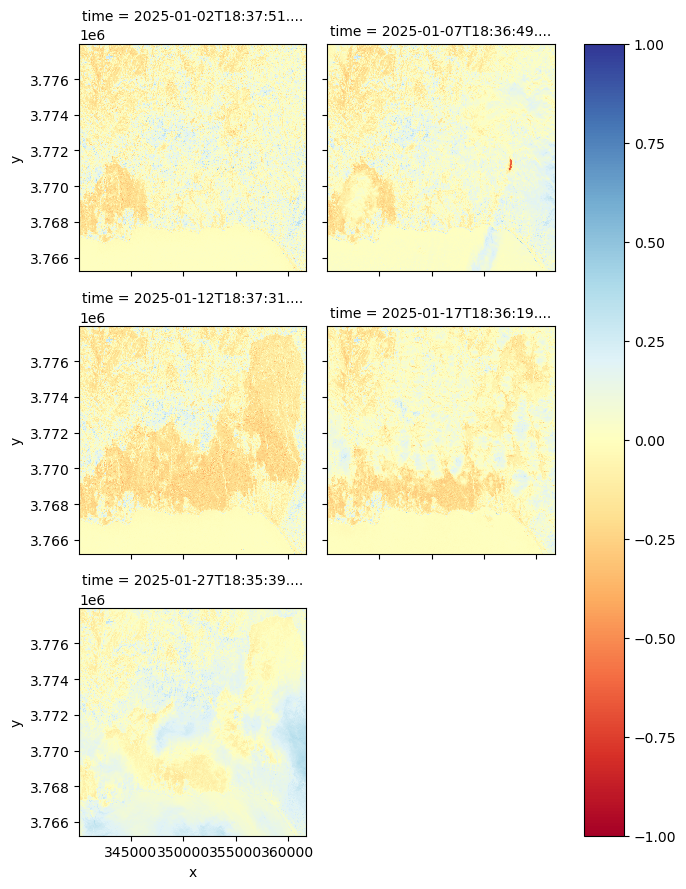

In [13]:
ndmi_da = (s2_ds["B08"] - s2_ds["B11"]) / (s2_ds["B08"] + s2_ds["B11"])
ndmi_da.plot.imshow(col='time',col_wrap=2,robust=True,cmap='RdYlBu',vmin=-1,vmax=1)

**Moisture Stress Index (MSI)**
* Moisture Stress Index is used for canopy stress analysis, productivity prediction and biophysical modeling. Interpretation of the MSI is inverted relative to other water vegetation indices; thus, higher values of the index indicate greater plant water stress and in inference, less soil moisture content. The values of this index range from 0 to more than 3 with the common range for green vegetation being 0.2 to 2 ([Sentinel Hub](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/msi/), [GIS Crack](https://giscrack.com/list-of-spectral-indices-for-sentinel-and-landsat/)).

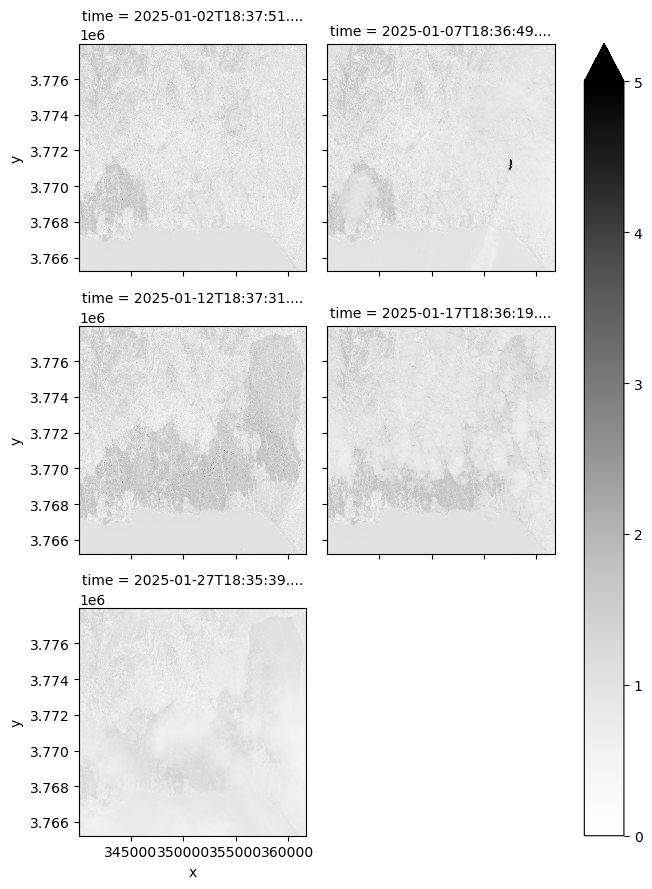

In [14]:
msi_da = s2_ds["B11"] / s2_ds["B08"]
msi_da.plot.imshow(col='time',col_wrap=2,robust=True,cmap='Grays',vmin=0,vmax=5)

**Green Coverage Index (GCI)**
* Green Chlorophyll Index is used to estimate the content of leaf chlorophyll in various species of plants. The chlorophyll content reflects the physiological state of vegetation; it decreases in stressed plants and can therefore be used as a measurement of plant health ([EOS, 2019](https://eos.com/blog/vegetation-indices/)).

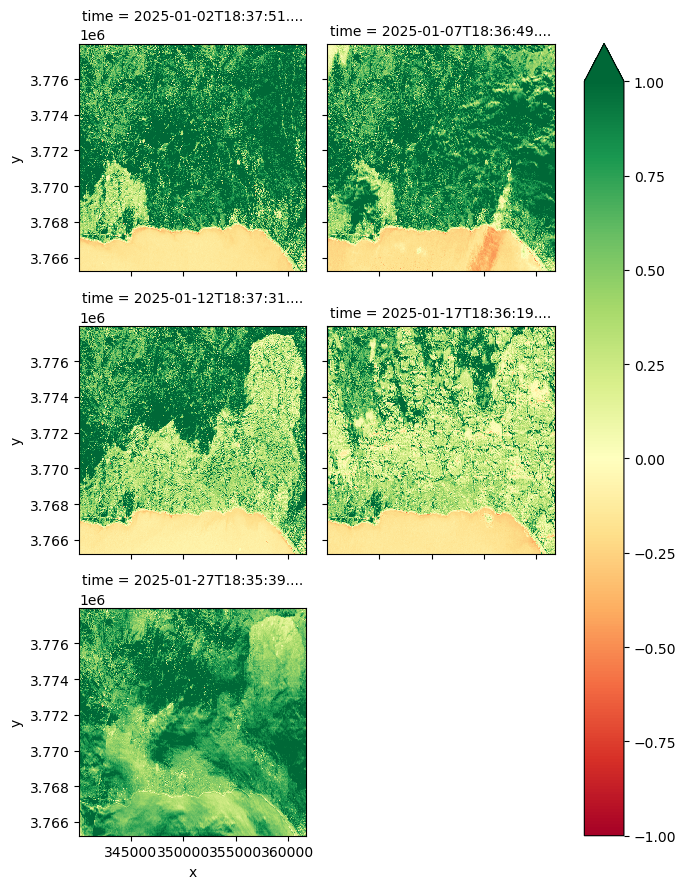

In [15]:
gci_da = (s2_ds["B09"] / s2_ds["B03"]) -1
gci_da.plot.imshow(col='time',col_wrap=2,robust=True,cmap='RdYlGn',vmin=-1,vmax=1)

**Normalized Burned Ratio Index (NBRI)**
* Forest fires are a severe manmade or natural phenomena that destroy natural recourses, live stock, unbalances the local environments, release huge amount of Green House Gases etc. NBRI takes advantage of the near infrared and short wave infrared spectral bands, which are sensitive in vegetation changes, to detect burned areas and monitor the recovery of the ecosystem ([GIS Crack](https://giscrack.com/list-of-spectral-indices-for-sentinel-and-landsat/)).

In [2]:
nbri_da = (s2_ds["B08"] - s2_ds["B12"]) / (s2_ds["B08"] + s2_ds["B12"])
nbri_da.plot.imshow(col='time',col_wrap=2,robust=True,cmap='RdBu',vmin=-1,vmax=1)


NameError: name 's2_ds' is not defined

Severity values
* [NBRI Severity values](https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/vegetation-indices-in-python/calculate-dNBR-Landsat-8/)

In [1]:
prefire_nbri_da = nbri_da.sel(time='2025-01-02')
postfire_nbri_da = nbri_da.sel(time='2025-01-27')
delta_bri = prefire_nbri_da - postfire_nbri_da
delta_bri.plot.imshow(col='time', robust=True,cmap='RdYlGn',vmin=-1,vmax=1)

NameError: name 'nbri_da' is not defined

In [ ]:
prefire_date = prefire_nbri_da.sel(time='2025-01-02')
print(prefire_date)

In [ ]:
prefire_date.plot.imshow(col='time', robust=True,cmap='RdYlGn',vmin=-1,vmax=1)

In [4]:
# Use .where to find the 0 values in the data (use ChatGPT)
# Create a mask for 0 values or change the 0 values to Nan and rerun the steps